## Joplin Tornado Example

Please note that you might need additional dependencies to run this notebook, such as [geopandas](https://anaconda.org/conda-forge/geopandas) and [contextily](https://anaconda.org/conda-forge/contextily)

- Tornadoes occur at a high frequency in the United States compared with other natural hazards such as earthquakes and tsunamis but have a substantially smaller footprint. Even a single high-intensity tornado can result in high casualty rates and catastrophic economic losses and social consequences, particularly for small to medium communities.

- The city of Joplin, Missouri, USA, was hit by an EF-5 tornado on May 22, 2011.  The National Institute of Standards and Technology (NIST) conducted a technical investigation of this devastating event which can be found at: https://nvlpubs.nist.gov/nistpubs/NCSTAR/NIST.NCSTAR.3.pdf .  The Center for Risk-Based Community Resilience Planning  simulated this event for buildings and the electrical power network of Joplin in IN-CORE.  This Juypter Notebook provides an example of how to use IN-CORE.

- The initial damage prediction utilized the tornado path, tornado fragility curves representative of a 19- archetype building dataset, and EPN datasets.  Generic tornado paths are also available in IN-CORE, or a user defined tornado path is possible. 

- The functionality of the infrastructure was linked with a computable general equilibrium (CGE) economics model that computes specific community resilience metrics in economic terms.  A population dislocation model provides resilience metrics related to socio-demographics such as population dislocation as a function of income or race/ethnicity.

- This example demonstrates how users interact with the IN-CORE computational environment.

*This notebook was created by Lisa Wang, supervised by Professor John W. van de Lindt, with the help of the NCSA team (Jong Sung Lee, Chris Navarro, Diego Calderon, Chen Wang, Michal Ondrejcek, Gowtham Naraharisetty, and Yong Wook Kim). The population disclocation model was developed by Nathanael Rosenheim and the CGE model portion provided by Brad Hartman under the supervision of Professor Harvey Cutler.

#### Prerequisites

The following modules are necessary to run this notebook. To ensure dependencies are correct, install all modules through **conda**. 

| Module | Version | Notes |
| --- | --- | --- |
| pyIncore | =>0.5.3 | see: https://incore.ncsa.illinois.edu/doc/incore/install_pyincore.html |
| geopandas | 0.6.2 | used for working with geospatial data | 
| matplotlib | 3.1.2 | used for plotting results |
| contextily | 0.99.0 | used for context geo-tiles |
| descartes | 1.1.0 | used for visualization of geometric objects as matplotlib paths |


### 1. Hazard, Data, and Fragility

This section introduces the input for the infrastructure damage analysis including the tornado path, building dataset, and building fragility curves for tornado.

In [14]:
from pathlib import Path

import matplotlib.pyplot as plt  # This cell is used to import python libraries to visualize the analysis outputs.
import matplotlib.image as mpimg
import geopandas as gpd
import pandas as pd
import numpy as np
import contextily as ctx

#### 1.1. Tornado Path

This figure shows the 2011 Joplin tornado path with EF zones provided in the legend. The tornado path represents the wind speed within the vortex (multi-vortex in the case of Joplin) that was estimated to have EF5 wind speeds of more than 200 mph, reducing to EF4 wind speeds as the areas move outward from the vortex, and eventually reaching EF1 zone. (Attary et al. 2018)

/Users/diegoc/.local/lib/python3.7/site-packages/pyproj/transformer.py:92: UserWarning:

`from_crs` is deprecated and will be removed in 2.2.0. Please use `from_proj` instead.



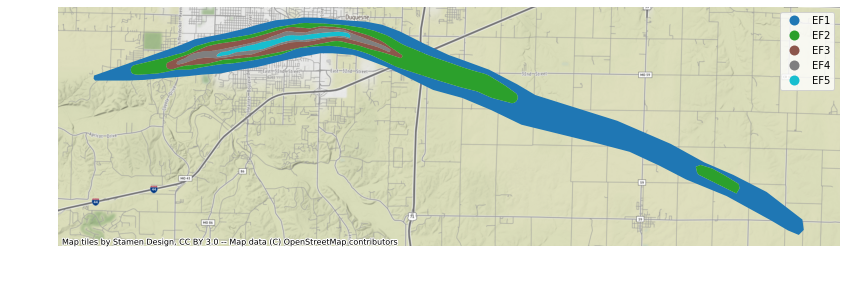

In [15]:
path = Path('5d07cbe9b9219c065b819103/joplin_path_wgs84.shp')
shp_path = Path(path)
tornado = gpd.read_file(shp_path)
tornado = tornado.to_crs(epsg=3857)
fig, ax = plt.subplots(figsize=(14, 6))
tornado.plot(column='ef_rating', categorical=True,legend=True,ax=ax)  
ctx.add_basemap(ax)
ax.set_axis_off()

plt.show()

#### 1.2. Building Archetypes

The 19 archetype buildings are used herein to represent the Joplin community. The selected building archetypes consider building characteristics such as footprint area, roof structure, number of stories, and so on. (Attary et al. 2018, Memari et al. 2018)

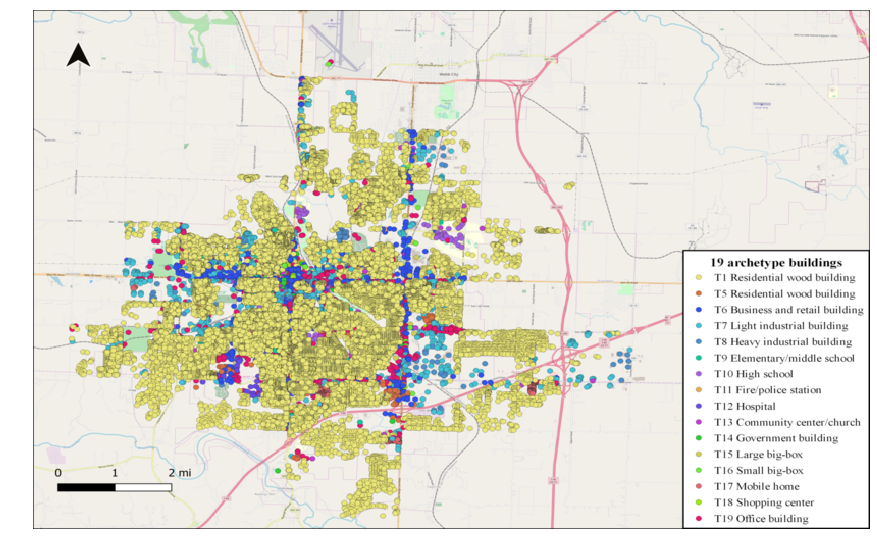

In [16]:
img = mpimg.imread('Images/Joplin building archetypes.png')  # The layout of the building dataset shown in GIS software.
plt.rcParams['figure.figsize'] = [15, 13]
plt.axis('off')
plt.imshow(img)

/Users/diegoc/.local/lib/python3.7/site-packages/pyproj/transformer.py:92: UserWarning:

`from_crs` is deprecated and will be removed in 2.2.0. Please use `from_proj` instead.



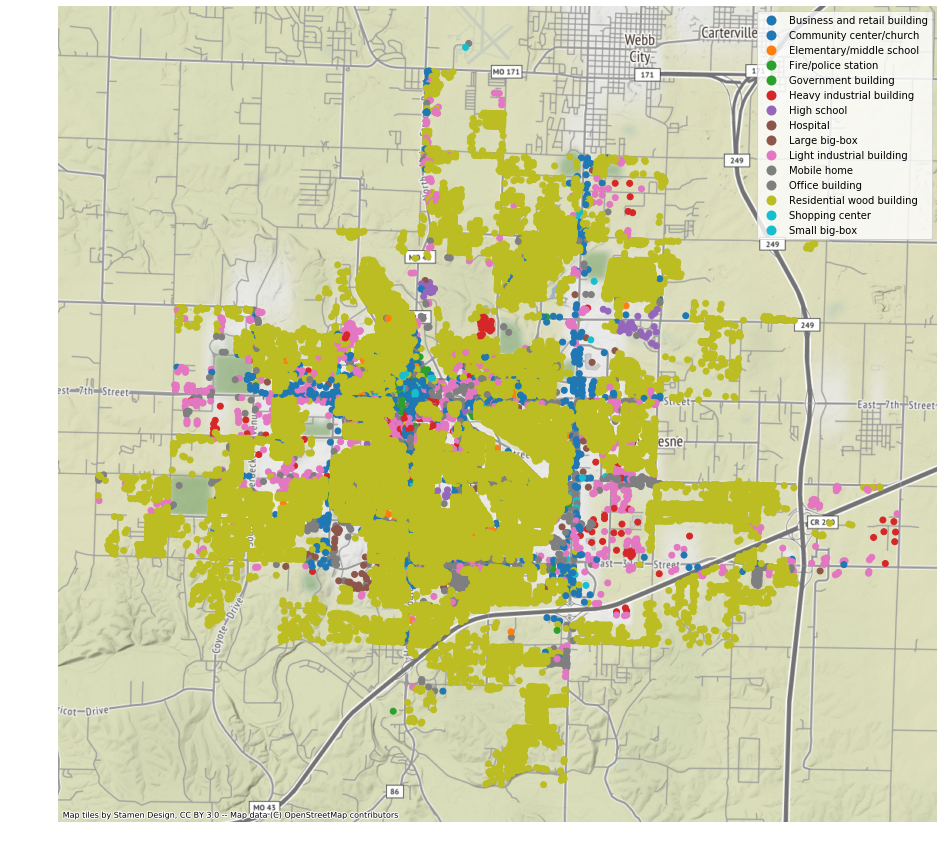

In [17]:
path = Path('joplin_bldg_inventory_v6_LW/joplin_bldg_inventory_v6.shp')
shp_path = Path(path)

building = gpd.read_file(shp_path)  # The layout of the building dataset shown in Python.
building = building.to_crs(epsg=3857)
fig, ax = plt.subplots(figsize=(17, 15))
building.plot(column='types', categorical=True, legend=True, ax=ax)
ctx.add_basemap(ax)
ax.set_axis_off()

plt.show()

#### 1.3. Fragility Curves

The fragility curves for these 19 building types in the four damage states are shown below, which covers the entire range of wind speeds associated with tornadoes (Attary et al. 2018, Memari et al. 2018).

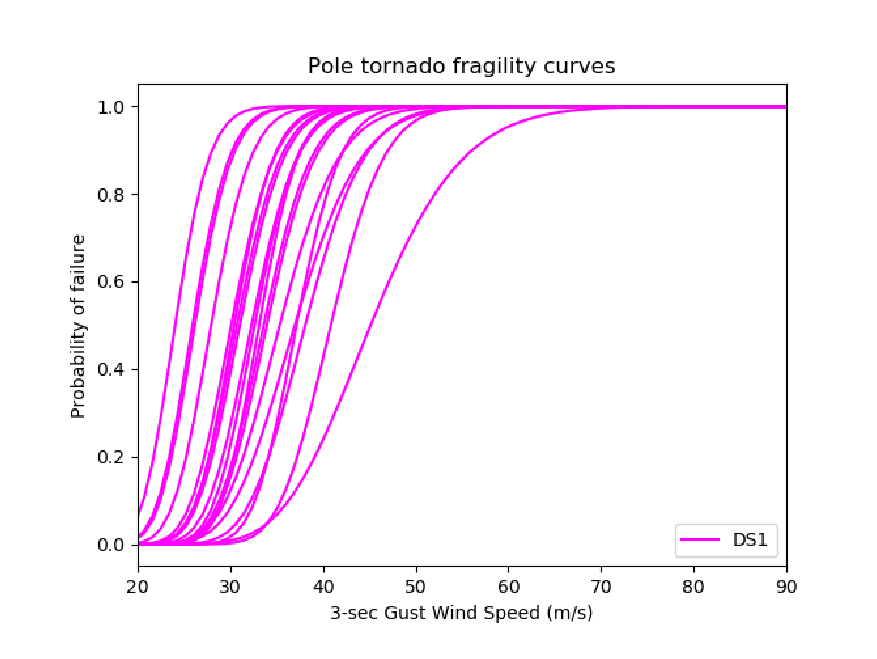

In [18]:
img_DS1 = mpimg.imread('Images/DS1.png')  # Damage State 1
plt.rcParams['figure.figsize'] = [15, 13]
plt.axis('off')
plt.imshow(img_DS1)

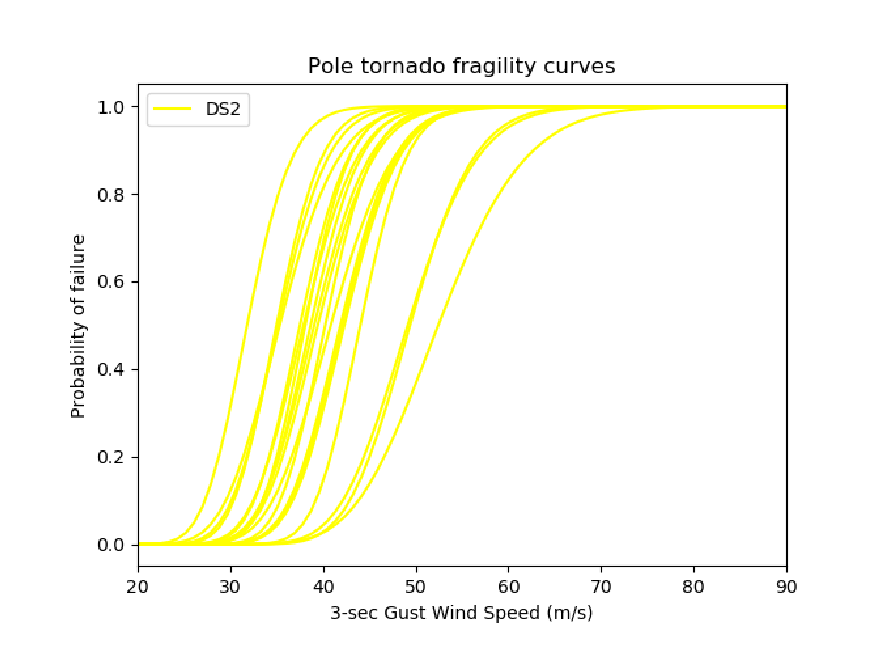

In [19]:
img_DS2 = mpimg.imread('Images/DS2.png')  # Damage State 2
plt.rcParams['figure.figsize'] = [15, 13]
plt.axis('off')
plt.imshow(img_DS2)

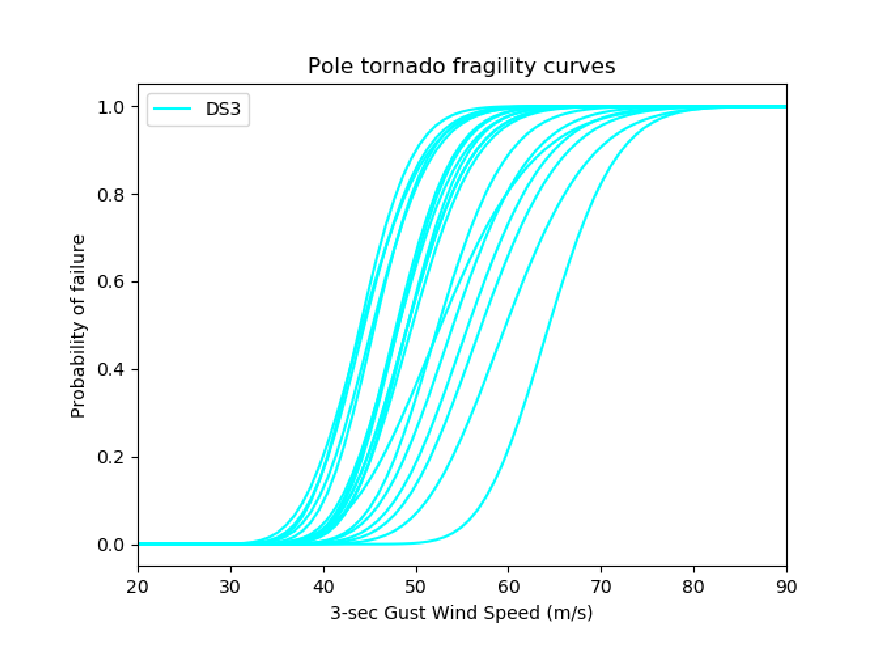

In [20]:
img_DS3 = mpimg.imread('Images/DS3.png')  # Damage State 3
plt.rcParams['figure.figsize'] = [15, 13]
plt.axis('off')
plt.imshow(img_DS3)

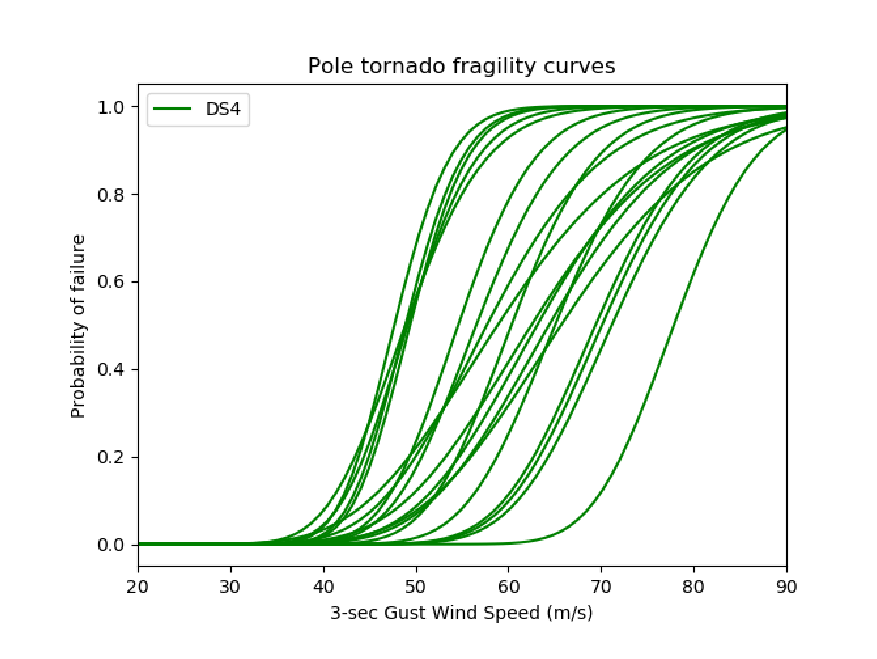

In [21]:
img_DS4 = mpimg.imread('Images/DS4.png')  # Damage State 4
plt.rcParams['figure.figsize'] = [15, 13]
plt.axis('off')
plt.imshow(img_DS4)

### 2. Infrastructure Damage Analysis

The models in this section implement the prediction of community-level damage to the buildings and Electric Power Network (EPN) for the 2011 Joplin tornado.

In [22]:
from pyincore import IncoreClient  
client = IncoreClient()  # The authentication service validates username/password and  
                         # approves users to access to other services.

#### 2.1. Buildings Damage

In [23]:
from pyincore.analyses.buildingdamage import BuildingDamage  # Import building damage module integrated into Pyincore.

In [24]:
bldg_dmg = BuildingDamage(client)  

hazard_type = "tornado"
hazard_id = "5d07cbeab9219c065b080930"  # The simulated EF-5 tornado shows geographical locations and the range
                                        # of wind speed of tornado hazard in Joplin.

mapping_id = "5d8942dfb9219c068ea795ea"  # Create a mapping to assign tornado fragilities to 19 building archetypes.

bldg_dataset_id = "5d4c61a2b9219c0689a397c9"  # Load the Joplin building dataset, which is a package of GIS files.

bldg_dmg.load_remote_input_dataset("buildings", bldg_dataset_id)  

Enter username: diegoac2
Enter password: ········
Dataset already exists locally. Reading from local cache.


In [25]:
result_name = "Joplin_bldg_dmg_result"  
bldg_dmg.set_parameter("result_name", result_name)
bldg_dmg.set_parameter("mapping_id", mapping_id)
bldg_dmg.set_parameter("hazard_type", hazard_type)
bldg_dmg.set_parameter("hazard_id", hazard_id)
bldg_dmg.set_parameter("num_cpu", 4)  # Define the result name, etc., and choose the number of CPU locally 
                                      # to run the model parallelly.

True

In [26]:
bldg_dmg.run_analysis()  # Run the building damage module to get building damage results for Joplin in a .csv file format. 
                         # The building damage results herein are referred to fragilities at three damage states (moderate, 
                         # heavy, complete) for 28152 buildings located in Joplin that fall within the tornado path or not.

True

##### 2.2. Electrical Power Facility - Substations Damage

In [27]:
from pyincore.analyses.epfdamage.epfdamage import EpfDamage # Import epf damage module integrated into Pyincore.

In [28]:
hazard_type = "tornado"
hazard_id = "5d07cbeab9219c065b080930"  # The simulated EF-5 tornado shows geographical locations and the range
                                        # of wind speed of tornado hazard in Joplin.
epf_substations_id = "5d92355bb9219c06ae7e386a"  

mapping_id = "5d8a326fb9219c068ea798e7"  # Create a mapping to assign tornado fragilities to substations.

epf_dmg = EpfDamage(client)  

epf_dmg.load_remote_input_dataset("epfs", epf_substations_id) 
                               # Load the Joplin substations dataset, which is a package of GIS files.

Dataset already exists locally. Reading from local cache.


In [29]:
result_name = "Joplin_epf_substations_dmg_result"
epf_dmg.set_parameter("result_name", result_name)
epf_dmg.set_parameter("mapping_id", mapping_id)
epf_dmg.set_parameter("hazard_type", hazard_type)
epf_dmg.set_parameter("hazard_id", hazard_id)
epf_dmg.set_parameter("num_cpu", 1)
epf_dmg.set_parameter("fragility_key", "substations")  # Define the result name, etc., and choose the number
                                                       # of CPU locally to run the model parallelly.

True

In [30]:
epf_dmg.run_analysis()  # Run the EPF damage module to get substations damage results for Joplin in a .csv file format. The 
                        # substations damage results herein are referred to fragilities at four damage states (insignificant, 
                        # moderate, extensive, complete) for 18 substations located in Joplin that fall within the tornado 
                        # path or not.

True

#### 2.3. Electrical Power Facility - Poles Damage

In [31]:
hazard_type = "tornado"
hazard_id = "5d07cbeab9219c065b080930"  # The simulated EF-5 tornado shows geographical locations and the range
                                        # of wind speed of tornado hazard in Joplin.
epf_poles_id = "5d923daab9219c06ae84afb0"  # Load the Joplin poles dataset, which is a package of GIS files.

mapping_id = "5d8a326fb9219c068ea798e7"  # Create a mapping to assign tornado fragilities to poles.

epf_dmg = EpfDamage(client) 

epf_dmg.load_remote_input_dataset("epfs", epf_poles_id)

Dataset already exists locally. Reading from local cache.


In [32]:
result_name = "Joplin_epf_poles_dmg_result"
epf_dmg.set_parameter("result_name", result_name)
epf_dmg.set_parameter("mapping_id", mapping_id)
epf_dmg.set_parameter("hazard_type", hazard_type)
epf_dmg.set_parameter("hazard_id", hazard_id)
epf_dmg.set_parameter("num_cpu", 4)
epf_dmg.set_parameter("fragility_key", "poles")  # Define the result name, etc., and choose the number
                                                 # of CPU locally to run the model parallelly.

True

In [33]:
epf_dmg.run_analysis()  # Run the EPF damage module to get poles damage results for Joplin in a .csv file format. The poles 
                        # damage results herein are referred to fragilities at four damage states (insignificant, moderate, 
                        # extensive, complete) for 23857 poles located in Joplin that fall within the tornado path or not.

True

### 3. Monte Carlo Simulation

Researchers can use Monte Carlo Simulation to estimate the probability of each building being in a particular damage state.  This example uses 500 iterations to determine the failure probability of buildings reaching damage state 2, damage state 3, and damage state 4. Users can run 10000 samples or even more for a more accurate Monte Carlo Simulation to determine the building failure probabilities.  Note that this takes several minutes and we are working on developing a more efficient algorithm.

#### 3.1. Building Failure Probability

In [34]:
from pyincore.analyses.montecarlofailureprobability import MonteCarloFailureProbability 
                                                  # Import Monte Carlo failure probability module integrated into Pyincore.

In [35]:
mc = MonteCarloFailureProbability(client)
mc.load_remote_input_dataset("damage", "5dbc9525b9219c06dd282637")  
                              #  Load the Joplin building damage results dataset generated from the previous model as an input.

Dataset already exists locally. Reading from local cache.


In [36]:
mc.set_parameter("result_name", "tornado_mc_failure_probability_buildings")
mc.set_parameter("num_cpu", 4)
mc.set_parameter("num_samples", 500)
mc.set_parameter("damage_interval_keys",                   # Define the damage states and failure states individually.
                 ["insignific", "moderate", "heavy", "complete"])
mc.set_parameter("failure_state_keys", ["complete", "heavy", "moderate"]) 

True

In [37]:
mc.run_analysis()  # Run the Monte Carlo Simulation module to obtain the building failure probabilities. The building failure
                   # probabilities herein only consider the physical damage without the interdependency.

True

##### 3.2. Building Damage Spatial Distribution Results

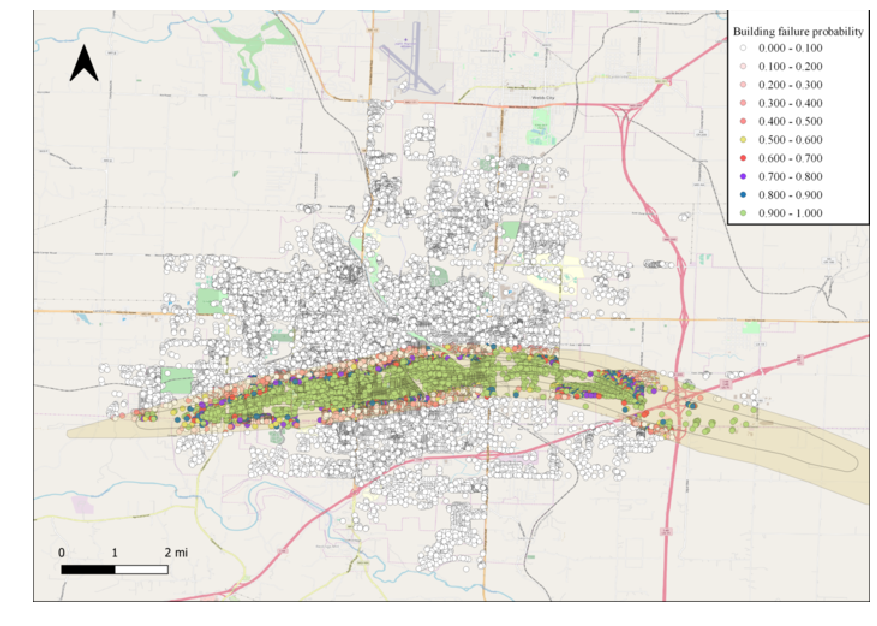

In [38]:
img = mpimg.imread('Images/Building damage spatial results.png') 
plt.rcParams['figure.figsize'] = [15, 13] 
plt.axis('off')
plt.imshow(img)   # The layout of the building damage spatial distribution results shown in GIS software.

/Users/diegoc/.local/lib/python3.7/site-packages/pyproj/transformer.py:92: UserWarning:

`from_crs` is deprecated and will be removed in 2.2.0. Please use `from_proj` instead.



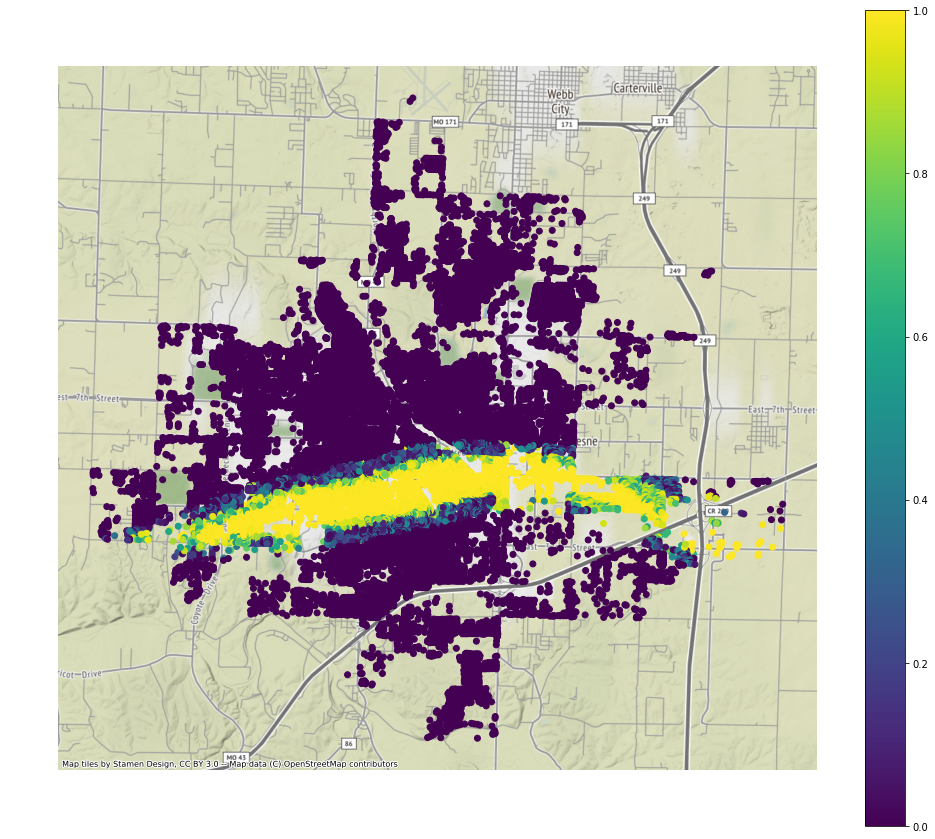

In [39]:
shp_path = Path('joplin_bldg_inventory_v6_LW/joplin_bldg_inventory_v6.shp')
blgs = gpd.read_file(shp_path)
blgs = blgs.to_crs(epsg=3857)

fig, ax = plt.subplots(figsize=(17, 15))
blgs.plot(column='failure',legend='True',ax=ax)
ctx.add_basemap(ax)
ax.set_axis_off()

plt.show()   # The layout of the building damage spatial distribution results shown in Python.

### 4. Infrastructure Functionality Analysis

The functionality analysis module below can be used to calculate building functionality probabilities considering two situations: buildings are in at least a damage state 2 or greater or buildings are not damaged but electric power is not available to the building. Whether buildings can receive electrical power is assumed to depend on the interdependency between buildings and substations, and between buildings and poles in close proximity. If both the nearest pole to the building and the substation where buildings belong to its service area are functional, buildings are considered to be able to receive electric power.

#### 4.1. Building Functionality Probability

In [40]:
from pyincore.analyses.buildingfunctionality.buildingfunctionality import BuildingFunctionality
                                            # Import building functionality module integrated into Pyincore.

In [41]:
bldg_func = BuildingFunctionality(client)
bldg_func.load_remote_input_dataset("building_damage_mcs_samples", "5ddc40dfb9219c06d4e28b71")
bldg_func.load_remote_input_dataset("substations_damage_mcs_samples", "5ddc4255b9219c06d4e38a47")
bldg_func.load_remote_input_dataset("poles_damage_mcs_samples", "5ddc42cdb9219c06d4e488e9")
   # Load the datasets of building samples, substation samples, and pole samples. All of the samples are randomly generated
   # using the Monte Carlo Simulation module introduced in the previous section.

Dataset already exists locally. Reading from local cache.
Dataset already exists locally. Reading from local cache.
Dataset already exists locally. Reading from local cache.


In [42]:
bldg_func.load_remote_input_dataset("interdependency_dictionary", "5dcf4a34b9219ca5e4118312")  
   # Load the datasets of the interdependency table between buildings and substations, and between buildings and poles.

Dataset already exists locally. Reading from local cache.


In [43]:
bldg_func.set_parameter("result_name", "Joplin_mcs_functionality_probability")
bldg_func.set_parameter("num_samples", 500)   # Define the result name, and choose the number 
                                         # of CPU locally to run the model parallelly.

True

In [44]:
bldg_func.run_analysis()  # Run the module to obtain the building functionality probabilities. 

True

#### 4.2. Building Functionality Spatial Distribution Results

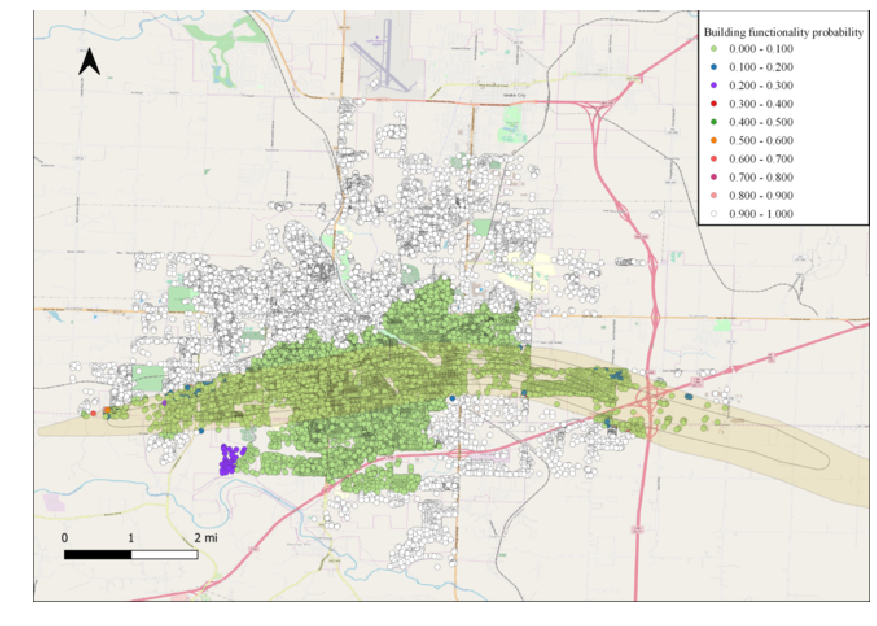

In [45]:
img = mpimg.imread('Images/Building functionality spatial results.png')
plt.rcParams['figure.figsize'] = [15, 13]
plt.axis('off')
plt.imshow(img)   # The layout of the building functionality spatial distribution results shown in GIS software.

/Users/diegoc/.local/lib/python3.7/site-packages/pyproj/transformer.py:92: UserWarning:

`from_crs` is deprecated and will be removed in 2.2.0. Please use `from_proj` instead.



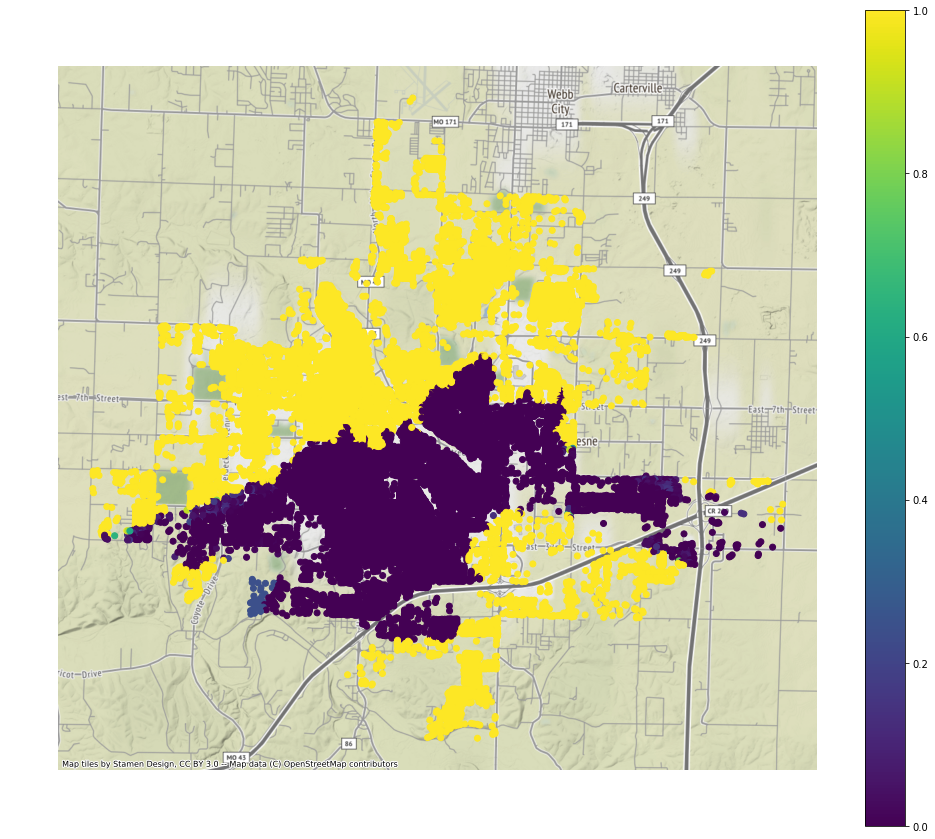

In [46]:
shp_path = Path('joplin_bldg_inventory_v6_LW/joplin_bldg_inventory_v6.shp')
blgs = gpd.read_file(shp_path)
blgs = blgs.to_crs(epsg=3857)
fig, ax = plt.subplots(figsize=(17, 15))
blgs.plot(column='fun',legend='True',ax=ax)
ctx.add_basemap(ax)
ax.set_axis_off()

plt.show()   # The layout of the building functionality spatial distribution results shown in Python.

##### 4.3. Physical Service Resilience Metrics

After finding the damage level for each component (buildings, substations, and poles) based on the components' fragility curves, their intrinsic failure status is expressed as a binary format with either failed (0) or not-failed (1). Then the failure status of all the buildings is updated by considering their dependencies with the corresponding electric power facilities. Each component generates 500 samples randomly with their failure status determined, and the percentage of building functional and nonfunctional could be calculated using the updated status of the same sample (such as sample #1) for all the buildings, illustrated herein as an example.

The percent shown in the horizontal bar below refers to the number of nonfunctional/damaged buildings divided by all buildings in Joplin. For example, the mean percentage of building nonfunctional is 51.92%, and the standard deviation percentage is 0.88 % shown as an error bar. The percentage is two times more than the percent of building in damage is because three substations fall within the tornado path. Consequently, there is a significant probability for buildings located in their service area cannot be available to access the electric power even though some buildings themselves are still safe and operational in the immediate response of the tornado hazard. It is worthy to note that a random tornado path analysis will produce a larger standard deviation of building damage and building functionality.

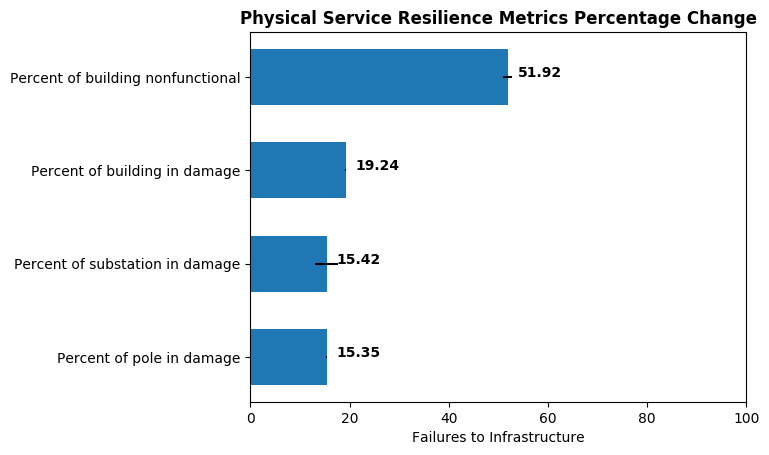

In [47]:
ps = pd.read_csv(Path('Results/physical-service.csv')) 
plt.rcdefaults()
fig, ax = plt.subplots()

infra = ('Percent of building nonfunctional', 'Percent of building in damage', 'Percent of substation in damage',\
         'Percent of pole in damage')
y_pos = np.arange(len(infra))
performance = ps['percentage']

for i, v in enumerate(round(performance,2)):
    ax.text(v + 2, i, str(v), color='black', fontweight='bold')
    
ax.barh(y_pos, performance, xerr=ps['std'], align='center', height=0.6)
ax.set_yticks(y_pos)
ax.set_yticklabels(infra)
ax.invert_yaxis()
ax.set_xlabel('Failures to Infrastructure')
ax.set_title('Physical Service Resilience Metrics Percentage Change',fontsize = 12,weight='bold')
plt.xlim(0, 100)
plt.show()  # Physical service resilience metrics percentage change immediately after the simulated EF-5 tornado.

### 5. Economic analysis

#### 5.1. Computable General Equilibrium (CGE) Model

A computable general equilibrium (CGE) model is based on fundamental economic principles. A CGE model uses multiple data sources to model the interactions of households, firms and relevant government entities as they contribute to economic activity. The model is based on (1) utility-maximizing households that supply labor and capital, using the proceeds to pay for goods and services (both locally produced and imported) and taxes;
(2) the production sector, with perfectly competitive, profit-maximizing firms using intermediate inputs, capital, land and labor to produce goods and services for both domestic consumption and export; (3) the government sector that collects taxes and uses tax revenues in order to finance the provision of public services; and (4) the rest of the world.

In [48]:
from pyincore.analyses.joplincgeanalysis import JoplinCGEModel

In [49]:
joplin_cge = JoplinCGEModel(client)

Each of the objects with string IDs below refer to datasets used as inputs in the CGE model.

In [50]:
# SAM
# Social accounting matrix (SAM) contains data for firms, households and government which are organized 
# in a way to represent the interactions of all three entities in a typical economy
SAM = "5dd85ae7b9219c06d4da8de4"

# CAPITAL COMP
# BB is a matrix which describes how investment in physical infrastructure is transformed into functioning capital such as commercial and residential buildings. 
# These data are collected from the Bureau of Economic Analysis (BEA).
BB = "5dc1e620b9219c06dd2f473a"

IOUT = "5dc1e6d8b9219c06dd2f475e" # This is matrix that describes the transfer of tax revenue collected by the local government to help finance local government expenditures. \n",
MISC = "5dc1e736b9219c06dd2f4782" # This is the name of a file that contains data for commercial sector employment and physical capital. It also contains data for the number of households and working households in the economy. \n",
MISCH = "5dc1e7b5b9219c06dd2f47a6" # A file that contains elasticities for the supply of labor with respect to paying income taxes.\n",
LANDCAP = "5dc1e810b9219c06dd2f47ca" # Contains information regarding elasticity values for the response of changes in the price of physical capital with respect to the supply of investment.\n",
EMPLOY = "5dc1e85ab9219c06dd2f47ee" # Table name containing data for commercial sector employment.\n",
IGTD = "5dc1e895b9219c06dd2f4812" # This variable represents a matrix describing the transfer of taxes collected to a variable which permits governments to spend the tax revenue on workers and intermediate inputs.\n",
TAUFF = "5dc1e8eeb9219c06dd2f4836" # Represents social security tax rates\n",
JOBCR = "5dc1e962b9219c06dd2f487e" # This is a matrix describing the supply of workers coming from each household group in the economy. \n",
OUTCR = "5dc1e9aeb9219c06dd2f48bc" # This a matrix describing the number of workers who live in Joplin but commute outside of town to work.\n",
sector_shocks = "5dd84292b9219c06d4da8c93" # This is the aggregation of building functionality states to capital shocks per sector.\n"

In [51]:
# Set analysis input datasets
joplin_cge.load_remote_input_dataset("SAM", SAM)
joplin_cge.load_remote_input_dataset("BB", BB)
joplin_cge.load_remote_input_dataset("IOUT", IOUT)
joplin_cge.load_remote_input_dataset("MISC", MISC)
joplin_cge.load_remote_input_dataset("MISCH", MISCH)
joplin_cge.load_remote_input_dataset("LANDCAP", LANDCAP)
joplin_cge.load_remote_input_dataset("EMPLOY", EMPLOY)
joplin_cge.load_remote_input_dataset("IGTD", IGTD)
joplin_cge.load_remote_input_dataset("TAUFF", TAUFF)
joplin_cge.load_remote_input_dataset("JOBCR", JOBCR)
joplin_cge.load_remote_input_dataset("OUTCR", OUTCR)
joplin_cge.load_remote_input_dataset("sector_shocks", sector_shocks)

The solver_path variable points to the absolute path for where the ipopt solver is installed. To know the absolute path of the ipopt solver in your local machine, open a terminal window, activate your pyIncore environment, and run the following command according to your OS:
* on Mac: open a terminal window, activate your conda environment and type "which ipopt". Paste the resulting path below.
* on Windows: open a command terminal, activate your conda environment and type "whereipopt". Paste the resulting path below.

In [52]:
# Set analysis parameters
joplin_cge.set_parameter("solver_path", "ipopt")
joplin_cge.set_parameter("model_iterations", 1)

True

In [53]:
# Run Joplin CGE model analysis
joplin_cge.run_analysis()

/Users/diegoc/.local/lib/python3.7/site-packages/pandas/core/indexing.py:1494: FutureWarning:


Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike



Ipopt 3.12.12: 

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

This is Ipopt version 3.12.12, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Too few degrees of freedom (n_x = 490, n_c = 528).
  Trying fixed_variable_treatment = RELAX_BOUNDS

Number of nonzeros in equality constraint Jacobian...:     2890
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:     3366

Total number of variables............................:      687
                     variables with only lower bounds:        0
                variables with

Constraint violation....:   5.4569682106375694e-11    5.4569682106375694e-11
Complementarity.........:   4.4397848633184868e-09    4.4397848633184868e-09
Overall NLP error.......:   4.4397848633184868e-09    4.4397848633184868e-09


Number of objective function evaluations             = 11
Number of objective gradient evaluations             = 11
Number of equality constraint evaluations            = 11
Number of inequality constraint evaluations          = 0
Number of equality constraint Jacobian evaluations   = 11
Number of inequality constraint Jacobian evaluations = 0
Number of Lagrangian Hessian evaluations             = 10
Total CPU secs in IPOPT (w/o function evaluations)   =      0.246
Total CPU secs in NLP function evaluations           =      0.014

EXIT: Optimal Solution Found.
Ipopt 3.12.12: warm_start_init_point=yes
warm_start_bound_push=1e-06
warm_start_mult_bound_push=1e-06
mu_init=1e-06


******************************************************************************
Th

True

#### 5.2. Economic Resilience Metrics

#### *Percent Reduction of  Domestic Supply*

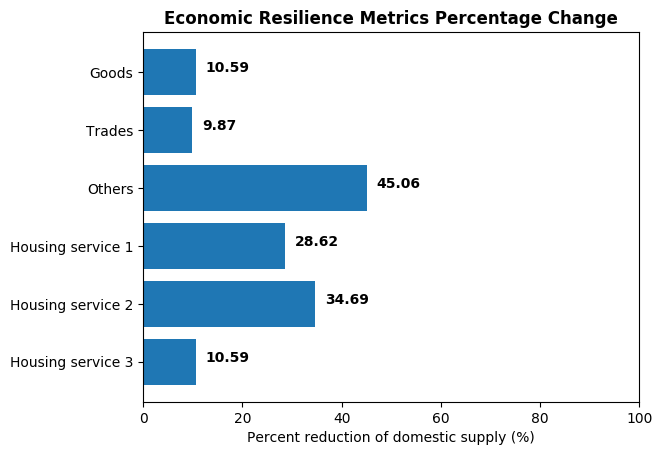

In [54]:
ds = pd.read_csv(Path('Results/domestic-supply.csv'))
plt.rcdefaults()
fig, ax = plt.subplots()

sectors = ('Goods', 'Trades', 'Others', 'Housing service 1', 'Housing service 2','Housing service 3')
y_pos = np.arange(len(sectors))
performance = ds['percentage']

for i, v in enumerate(round(performance,2)):
    ax.text(v + 2, i, str(v), color='black', fontweight='bold')
    
ax.barh(y_pos, performance, align='center', height=0.8)
ax.set_yticks(y_pos)
ax.set_yticklabels(sectors)
ax.invert_yaxis()
ax.set_xlabel('Percent reduction of domestic supply (%)')
ax.set_title('Economic Resilience Metrics Percentage Change',fontsize = 12,weight='bold')
plt.xlim(0, 100)
plt.show()

#### *Percent Reduction of  Household Income*

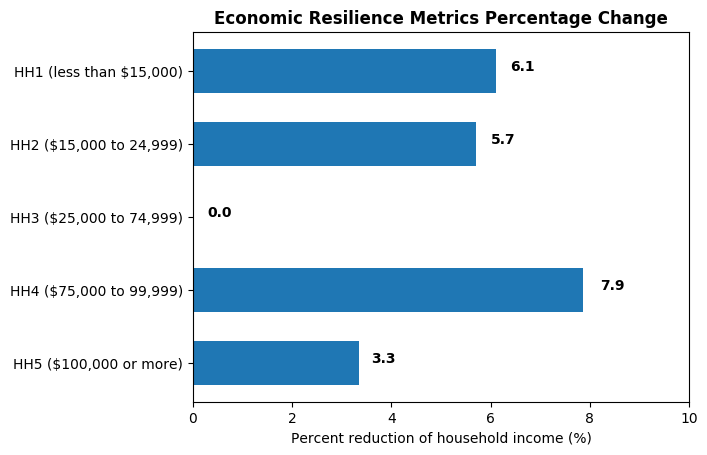

In [55]:
hi = pd.read_csv(Path('Results/household-income.csv'))
plt.rcdefaults()
fig, ax = plt.subplots()

household = ('HH1 (less than $15,000)', 'HH2 ($15,000 to 24,999)', 'HH3 ($25,000 to 74,999)', \
           'HH4 ($75,000 to 99,999)', 'HH5 ($100,000 or more)')
y_pos = np.arange(len(household))
performance = hi['percentage']

for i, v in enumerate(round(performance,1)):
    ax.text(v+0.3, i, str(v), color='black', fontweight='bold')
    
ax.barh(y_pos, performance, align='center', height=0.6)
ax.set_yticks(y_pos)
ax.set_yticklabels(household)
ax.invert_yaxis()
ax.set_xlabel('Percent reduction of household income (%)')
ax.set_title('Economic Resilience Metrics Percentage Change',fontsize = 12,weight='bold')
plt.xlim(0, 10)
plt.show()

##### *Percent Reduction of Employment*

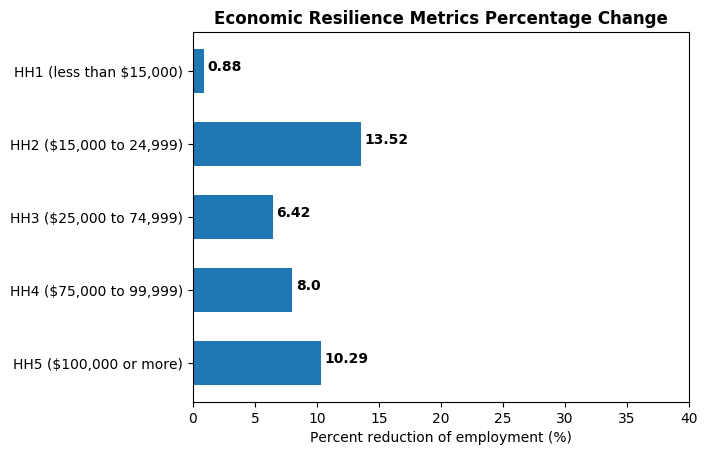

In [56]:
em = pd.read_csv(Path('Results/employment.csv'))
plt.rcdefaults()
fig, ax = plt.subplots()

household = ('HH1 (less than $15,000)', 'HH2 ($15,000 to 24,999)', 'HH3 ($25,000 to 74,999)', \
           'HH4 ($75,000 to 99,999)', 'HH5 ($100,000 or more)')
y_pos = np.arange(len(household))
performance = em['percentage']

for i, v in enumerate(round(performance,2)):
    ax.text(v+0.3, i, str(v), color='black', fontweight='bold')
    
ax.barh(y_pos, performance, align='center', height=0.6)
ax.set_yticks(y_pos)
ax.set_yticklabels(household)
ax.invert_yaxis()
ax.set_xlabel('Percent reduction of employment (%)')
ax.set_title('Economic Resilience Metrics Percentage Change',fontsize = 12,weight='bold')
plt.xlim(0, 40)
plt.show()

### 6. Sociological Analysis

This section introduces the sociology-based analysis which may be integrated with hazard and building damage analysis. In this example the damage to buildings drives the population dislocation algorithm at the household level. 

##### 6.1. Population Dislocation Model

The population dislocation model depends first on the allocation of detailed housing unit and household characteristic data to each residential building within the community. The allocation of detailed household characteristic data provides an estimate of the number of people that live within each structure. The dislocation model is based on household surveys, for a more detailed summary of the dislocation model please refer to Rosenheim, Guidotti, Gardoni, and Peacock 2019.

The model predicts which households within the community will be dislocated from their homes immediately following the hazard event.

In [57]:
from pyincore.analyses.populationdislocation import PopulationDislocation, PopulationDislocationUtil

In [58]:
pop_dis = PopulationDislocation(client)

In [59]:
# Joplin
building_dmg = "5dbc9525b9219c06dd282637"
housing_unit_alloc = "5dc1c196b9219c06dd2e3f0b"
bg_data = "5d4c9545b9219c0689b2358a"
value_loss = "5dfd1069fc33d500081555d8"

In [60]:
pop_dis.load_remote_input_dataset("building_dmg", building_dmg)
pop_dis.load_remote_input_dataset("housing_unit_allocation", housing_unit_alloc)
pop_dis.load_remote_input_dataset("block_group_data", bg_data)
pop_dis.load_remote_input_dataset("value_poss_param", value_loss)

Dataset already exists locally. Reading from local cache.
Dataset already exists locally. Reading from local cache.
Dataset already exists locally. Reading from local cache.
Dataset already exists locally. Reading from local cache.


In [61]:
result_name = "pop-dislocation-results"
seed = 1111

pop_dis.set_parameter("result_name", result_name)
pop_dis.set_parameter("seed", seed)


True

In [62]:
pop_dis.run_analysis()

True

#### 6.2. Sociological Resilience Metrics

#### *Percent of Population Dislocation*

The PopulationDislocation model predicts the probability of dislocation using a logistic regression model based on household level surveys from Hurricane Andrew in 1992, which was a major wind event. The logistic regression equation provides a probability of dislocation based on the value loss and the other factors. For more details on the population dislocation algorithm and the logistic regression model see Rosenheim et al 2019. 

To determine if a household dislocate a random value was uniformly sampled between 0 and 1: if this value was lower than the probability of dislocation, then the household was set to dislocate. The results below provide one example of how the output can be explored by population subgroups. The model is designed to run as part of a larger Monte Carlo Simulation.

In [64]:
population_dislocation = pop_dis.get_output_dataset("result")
# Convert dataset to Pandas DataFrame
df = population_dislocation.get_dataframe_from_csv()

# Select Housing units allocated to buildings
df = df.loc[df['archtype'].notnull()]

/miniconda3/envs/cge/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3214: DtypeWarning:

Columns (0,5,9,10,11,53) have mixed types. Specify dtype option on import or set low_memory=False.



In [65]:
table_title = "Total population by tenure status and dislocation."
pd.crosstab(df['ownershp'], df['dislocated'], df['numprec'], aggfunc = sum,
            dropna=True, margins=True, margins_name="Total").style.set_caption(table_title)

In [66]:
table_title = "Percent population by tenure status and dislocation."
pd.crosstab(df['ownershp'], df['dislocated'], df['numprec'], aggfunc = sum, normalize='index',
            dropna=True, margins=True, margins_name="Total").round(4)*100

dislocated  False  True 
ownershp                
1.0         59.36  40.64
2.0         61.54  38.46
Total       60.28  39.72

The variable ownershp represents the tenure status of households. When ownershp = 1 the housing unit is owner-occupied. When the ownershp = 2 the housing unit is renter-occupied. 
The results above provide the percent of the population predicted to dislocate based on tenure status. When the variable dislocated = True the household is predicted to dislocate.

### 7. References

Attary, N., van de Lindt, J. W., Mahmoud, H., Smith, S., Navarro, C. M., Kim, Y. W., & Lee, J. S. (2018). Hindcasting community-level building damage for the 2011 Joplin EF5 tornado. Natural Hazards, 93(3), 1295-1316.

Attary, N., van de Lindt, J. W., Mahmoud, H., & Smith, S. (2018). Hindcasting Community-Level Damage to the Interdependent Buildings and Electric Power Network after the 2011 Joplin, Missouri, Tornado. Natural Hazards Review, 20(1), 04018027.

Memari, M., Attary, N., Masoomi, H., Mahmoud, H., van de Lindt, J. W., Pilkington, S. F., & Ameri, M. R. (2018). Minimal building fragility portfolio for damage assessment of communities subjected to tornadoes. Journal of Structural Engineering, 144(7), 04018072.

Guidotti, R., Gardoni, P., & Rosenheim, N. (2019). Integration of physical infrastructure and social systems in communities’ reliability and resilience analysis. Reliability Engineering & System Safety, 185, 476-492. https://doi.org/10.1016/j.ress.2019.01.008

Rosenheim, N., Guidotti, R., Gardoni, P., & Peacock, W. (2019). Integration of detailed household and housing unit characteristic data with critical infrastructure for post-hazard resilience modeling. Sustainable and Resilient Infrastructure. https://doi.org/10.1080/23789689.2019.1681821